In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.models import model_from_json

In [4]:
df1 = pd.read_csv('eng_open.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
df_input = df1[['High Change', 'Low Change', 'High/Close', 'Low/Close', 'Spread',
       'Volume Diff', 'Vol change', 'Return ewm', 'Oil return', 'SU return',
       'TSX return', 'Gas return', 'Return', 'Chaikin']]
df_input

,High Change,Low Change,High/Close,Low/Close,Spread,Volume Diff,Vol change,Return ewm,Oil return,SU return,TSX return,Gas return,Return,Chaikin
Date,,,,,,,,,,,,,,
2010-01-06,0.008437,-0.016291,0.033755,-0.006329,0.583621,1473200.0,1.207739,-0.011999,0.017244,0.013427,0.004744,0.065993,-0.022681,7.105000e+05
2010-01-07,-0.029387,-0.011889,0.006561,-0.015026,0.313312,-327400.0,-0.121574,-0.006109,-0.006251,-0.010956,-0.004772,-0.033783,-0.003164,1.915500e+05
2010-01-08,-0.001262,0.011817,0.003592,-0.005071,0.125939,-708800.0,-0.299628,-0.000908,0.001089,-0.003349,0.005577,-0.009817,0.001693,-2.586250e+05
2010-01-11,0.000631,-0.006159,0.011277,-0.004255,0.224233,161600.0,0.097537,-0.004951,-0.002779,-0.002843,-0.000561,-0.051313,-0.006972,-4.851250e+04
2010-01-12,-0.007153,0.000428,0.004684,-0.003194,0.113652,-606000.0,-0.333260,-0.002076,-0.020965,-0.018403,-0.010622,0.025119,-0.000638,-3.272562e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-13,0.023494,0.011546,0.001138,-0.023208,1.070000,-4180500.0,-0.357959,0.018062,-0.005638,-0.017939,-0.002841,-0.009444,0.023045,-1.014769e+06
2021-01-14,0.024545,0.024458,0.001333,-0.023101,1.100002,4354700.0,0.580766,0.022251,0.012474,0.042481,0.001305,-0.022369,0.024346,1.669966e+06
2021-01-15,0.003327,0.008186,0.007799,-0.012032,0.889999,2637700.0,0.222536,0.005344,-0.022587,-0.048085,-0.002734,0.026632,-0.003110,2.153833e+06


In [5]:
y = df1[["Pos"]]
y.head()

,Pos
Date,
2010-01-06,0
2010-01-07,1
2010-01-08,0
2010-01-11,0
2010-01-12,0


In [6]:
file_path = Path("eng_model_posneg.json")
with open(file_path, "r") as json_file:
    model_json = json_file.read()
loaded_model = model_from_json(model_json)

file_path = "eng_weights_posneg.h5"
loaded_model.load_weights(file_path)

In [7]:
split = int(0.7 * len(df1))

df = df1[split:]


df_test = df_input[split:]
df_test.shape

(811, 14)

In [8]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_input, y, test_size=0.3, random_state=42)

x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()


x_train_scaler.fit(x_train)
x_test_scaler.fit(x_test)


x_train = x_train_scaler.transform(x_train)
x_test = x_test_scaler.transform(df_test)

enc = OneHotEncoder()
enc.fit(y_train)

encoded_y_train = enc.transform(y_train).toarray()
encoded_y_test = enc.transform(y_test).toarray()

In [9]:
predicted = loaded_model.predict(x_test)
predicted = enc.inverse_transform(predicted).flatten().tolist()
df["tomo prediction"] = predicted

C:\Users\User\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
from sklearn.metrics import classification_report
print(classification_report(df.Pos, df["tomo prediction"]))

              precision    recall  f1-score   support

           0       0.55      0.07      0.12       376
           1       0.54      0.95      0.69       435

    accuracy                           0.54       811
   macro avg       0.55      0.51      0.41       811
weighted avg       0.55      0.54      0.43       811



In [11]:
from sklearn.metrics import classification_report
print(classification_report(df.Pos, df["tomo prediction"]))

              precision    recall  f1-score   support

           0       0.55      0.07      0.12       376
           1       0.54      0.95      0.69       435

    accuracy                           0.54       811
   macro avg       0.55      0.51      0.41       811
weighted avg       0.55      0.54      0.43       811



In [12]:
df = df[["Open", "tomo prediction", "Dividends"]]
df["Pos"] = df1["Pos"]
df["prediction"] = df["tomo prediction"].shift(1)
df["last"] = df["prediction"].shift(1)
df = df.dropna()
back_csv_data = df.to_csv('Enbridge_backtest.csv', index = True) 

In [22]:
import math
capital = float(100)
pos = float(1)
neg = float(0)

def Backtest(capital, split, year):
    initial_capital = capital
    df1 = df.loc[year:]
    shares = math.floor((initial_capital/df1.iat[0,0]) * split)
    hold_shares = math.floor(initial_capital/df1.iat[0,0]) - shares
    capital = capital - ((df1.iat[0,0] * shares) + (df1.iat[0,0] * hold_shares))
    bnh_shares = math.floor(initial_capital/df1.iat[0,0])
    newshares = shares
    port = shares
    dividends = df.Dividends.loc[year:].cumsum()
    sells = 0
    buys = shares + hold_shares
    tradelist = []
        
    if split > 1:
        return "Split Invalid, Please Choose a number between 0 and 1 to determine how the % of your portfolio to be actively traded."
    
    elif year < "2017":
        return "We can only backtest back to 2017"
    
    elif capital < 0:
        return "Not Enough Starting Capital"
    
    else:
        for i, row in df1.iterrows():
            if row['prediction'] == 1.0 and row['last'] == 0.0:
                if capital > (row['Open'] * shares):
                    capital = capital - (row['Open'] * shares)
                    port = port + shares
                    buys = buys + shares
                    tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
                else: 
                    tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
        
            elif row['prediction'] == 0.0 and row['last'] == 1.0:
                if port >= shares:
                    capital = capital + (row['Open'] * shares)
                    port = port - shares
                    sells = sells + shares
                    tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
                elif port == 0:
                    tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
                else:
                    while port < newshares:
                        if port < newshares:
                            newshares = newshares - 1
                        elif port >= newshares:
                            capital = capital + (row['Open'] * newshares)
                            port = port - newshares
                            sells = sells + newshares
                            newshares = shares
                            tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
                            break
            else:
                tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
            
        tport = round(capital + (port * df1.iat[-1,0]) + (hold_shares * df1.iat[-1,0] + (dividends[-1] * hold_shares)),2)
                
        df1["port"] = tradelist
        df1["Open2"] = df1["Open"] * bnh_shares
        
        df1.plot(y=["port", "Open2"], kind="line")
        plt.legend(["Our Strategy", "Buy and Hold Strategy"])
                
        treturn = round(((tport - initial_capital)/initial_capital) * 100, 2)
        shop = round(((df1.iat[-1,0] - df1.iat[0,0])/df1.iat[0,0]) * 100, 2)
        bnh_leftover = initial_capital - (df1.iat[0,0] * bnh_shares)
        bnh = round(((df1.iat[-1,0] * bnh_shares) + bnh_leftover + (dividends[-1] * bnh_shares)),2)
        bnh_per = round(((bnh - (initial_capital))/initial_capital)*100, 2)
        print(f"Your Total Return is {treturn}%")
        print("")
        print(f"Total Portfolio Value is ${tport}")
        print("")
        print(f"Portfolio Breakdown")
        print(f"Avail. Funds: ${round(capital,2)}")
        print(f"Shares Value: ${round((tport-capital),2)}")
        print("")
        print(f"Enbridge return is {shop}%")
        print("-------------------------------------------")
        print(f"                        Return     Total")
        print(f"Our Strategy:            {treturn}%      {tport}")
        print(f"Buy and Hold Strategy:   {bnh_per}%      {bnh}")
        print(f"")
        print(f"-------------------------------------------")
        print(f"Buy Orders: {buys}")
        print(f"Sell Orders: {sells}")
        print(f"Total Trades: {buys+sells}")

C:\Users\User\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Your Total Return is 16.16%

Total Portfolio Value is $1161.57

Portfolio Breakdown
Avail. Funds: $1161.57
Shares Value: $-0.0

Enbridge return is 7.91%
-------------------------------------------
                        Return     Total
Our Strategy:            16.16%      1161.57
Buy and Hold Strategy:   30.64%      1306.43

-------------------------------------------
Buy Orders: 984
Sell Orders: 984
Total Trades: 1968


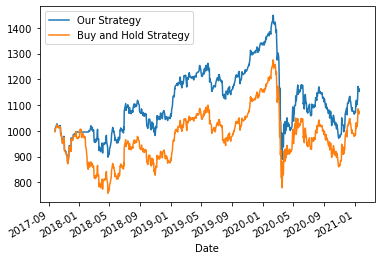

In [25]:
Backtest(1000,1,"2017")